# CNN - Parte 1 (solución)

En este ejercicio trabajaremos con la [base de datos CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html). Esta base de datos contiene un total de 60,000 imágenes a color de 32x32 clasificadas en 10 clases distintas. Las clases son: aviones, autos, pájaros, gatos, venados, perros, ranas, caballos, barcos y camiones (hay 6,000 imágenes de cada clase). Esta es una de las bases de datos más utilizadas para machine learning e inteligencia artificial.

El ejercicio está dividido en dos partes:
1. **Clasificación con un multi-layer perceptron**
2. Clasificación con una red CNN

### Resumen
En esta primera parte del ejercicio armaremos una red neuronal con un multi-layer perceptron para tratar de clasificar las imágenes en las 10 clases distintas.

Esta parte está dividida en:
1. Cargar la base de datos CIFAR-10
2. Pre-procesar los datos
3. Armado de la red neuronal
4. Compilación y entrenamiento
5. Evaluación de resultados

## 1  - Cargar la base de datos CIFAR-10
Primero cargaremos la base de datos que ya viene pre-cargada en los datasets de Keras.

In [1]:
import keras
from keras.datasets import cifar10

# Cargo los datos y los separo en datos y labels de test y train
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

/Users/rodrigobeceiro/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


A continuación visualizamos algunas de las imágenes de nuestra base de datos. Notar que la mala resolución es consecuencia de que son imágenes de 32x32. A pesar de esto, trataremos de clasificarlas correctamente.

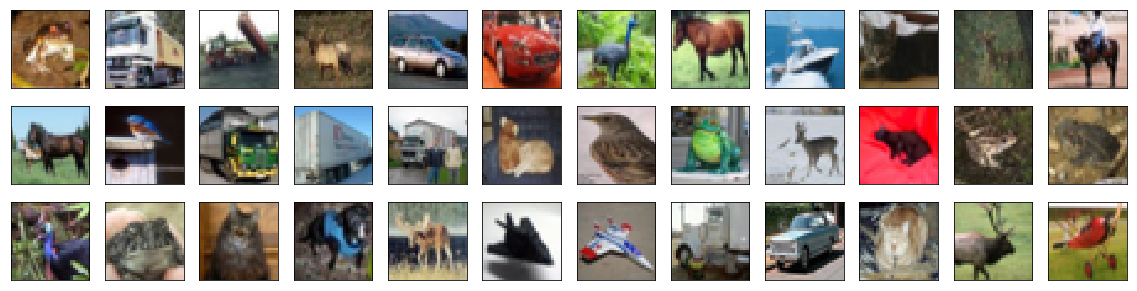

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(20,5))
for i in range(36):
    ax = fig.add_subplot(3, 12, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_train[i]))

## 2 - Pre-procesar los datos
Recordar que las imágenes son matrices donde la intensidad está reflejada por un número del 0 al 255.
Lo primero que haremos será normalizar la imágenes para que la intensidad solo varíe entre 0 y 1. Dividir cada pixel entre 255 para normalizar nuestros datos.

In [3]:
### SOLUCIÓN
# Re-escalar del rango [0,255] a [0,1]
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255 

Ahora separamos los datos en datos de test, train y validación. También aplicamos One-hot encoding para trabajar con nuestros labels.

In [4]:
from keras.utils import np_utils

# One-hot encoding
num_classes = len(np.unique(y_train))
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Separo los datos de train en datos de train y validación a partir de un punto arbitrario
(x_train, x_valid) = x_train[5000:], x_train[:5000]
(y_train, y_valid) = y_train[5000:], y_train[:5000]

** ¿Qué forma tendrá la variable x_train ahora? ¿Por qué?**

** Respuesta: ** Tendrá Nx32x32x3 donde N es la cantidad de datos de entrenamiento. El 3 es porque estoy trabajando con imágenes a color (R,G,B) y el 32x32 es el tamaño de mis imágenes.

In [5]:
# Verifico la forma de mis datos
print('Forma de x_train:', x_train.shape)

# Cuento cuántos datos tengo en cada dataset
print(x_train.shape[0], 'datos de entrenamiento')
print(x_test.shape[0], 'datos de test')
print(x_valid.shape[0], 'datos de validación')

Forma de x_train: (45000, 32, 32, 3)
45000 datos de entrenamiento
10000 datos de test
5000 datos de validación


## 3 - Armado de la red neuronal
Ahora debemos armar una red neuronal para clasificar las imágenes.

** Queremos usar una secuencia de capas densas. ¿Qué tipo de capa debe ir previo a la primer capa densa dado que estamos trabajando con imágenes? ¿Por qué? ** 

**Respuesta:** Precisamos una capa de Flatten para transformar las matrices multidimensionales en un vector.

** ¿Qué función de activación nos conviene utilizar en las capas intermedias? ** 

**Respuesta:** Relu porque estamos trabajando con imágenes.

** ¿Cuantos nodos precisa nuestra última capa densa? ¿Por qué? ** 

**Respuesta:** Precisa 10 nodos porque estamos clasificando en 10 clases distintas.

Armar una red neuronal que incluya:
1. La capa de entrada a nuestra red que precisamos dado que estamos trabajando con imágenes
2. Una capa densa de 1000 nodos y activación Relu
3. Una capa de dropout con factor 0.2
4. Una capa densa de 512 nodos y activación Relu
5. Una capa de dropout con factor 0.2
6. Una capa densa con la cantidad de nodos a la salida que precisamos y función de activación softmax.

In [6]:
### SOLUCIÓN
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten

model = Sequential()
model.add(Flatten(input_shape = x_train.shape[1:]))
model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              3073000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               512512    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 3,590,642
Trainable params: 3,590,642
Non-trainable params: 0
_________________________________________________________________


## 4 - Compilación y entrenamiento
Es momento de compilar y entrenar el modelo. Compilarlo con optimizador rmsprop y función de pérdida categorical crossentropy.

In [7]:
### SOLUCIÓN
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

Entrenar el modelo con 20 epochs, un batch_size de 32 y utilizando el callback 'checkpointer'. El callback utilizado guardará los mejores pesos en cada iteración. Esto nos permitirá descartar combinaciones de pesos que empeoren nuestros resultados con respecto a la iteración anterior.

In [ ]:
### SOLUCIÓN
from keras.callbacks import ModelCheckpoint   

#Defino callback
checkpointer = ModelCheckpoint(filepath='MLP.weights.best.hdf5', verbose=1, save_best_only=True)

#Entreno
model.fit(x_train, y_train, batch_size=32, epochs=20,
                 validation_data=(x_valid, y_valid), callbacks=[checkpointer], 
                 verbose=1, shuffle=True)

Ahora cargamos la mejor combinación de pesos que encontramos durante el entrenamiento con la función load_weights de Keras a partir del archivo que guardamos con el checkpoint durante el entrenamiento.

** ¿Qué se utiliza para determinar que es el mejor modelo? **

** Respuesta: ** La métrica definida sobre el dataset de validación. Por defecto es la precisión o accuracy.

In [ ]:
model.load_weights('MLP.weights.best.hdf5')

Ya que el entrenamiento de imágenes es muy largo, podemos usar un modelo guardado que ya fue entrenado con estos datos y parámetros arriba indicados. 

Debajo encontrarán también el código utilizado para guardar el modelo. Si desean entrenar ustedes mismos el modelo y hacer predicciones con él simplemente cambien los nombres de los archivos debajo o comenten todo el siguiente bloque de código.

In [8]:
from keras.models import load_model

# Creo un archivo HDF5: Incluirá la arquitectura y pesos del modelo.
#model.save('my_model_mlp.h5')
#Borro el modelo existente
#del model

# Levanto el modelo (arquitectura y pesos) de un archivo HDF5 guardado
model = load_model('saved_model_mlp.h5')

## 5 - Evaluación de resultados
Ahora utilizaremos la función evaluate de keras para determinar la precisión de nuestro modelo sobre los datos de test. Se puede leer sobre su uso [aquí](https://keras.io/models/model/).

In [9]:
### SOLUCIÓN
score = model.evaluate(x_test, y_test)
print('\n', 'Precisión en test:', score[1])

10000/10000 [==============================] - 3s 269us/step

 Precisión en test: 0.3937
